<a href="https://colab.research.google.com/github/hoangtrung1801/study-deep-learning/blob/main/violenece_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Violence Detection using Mediapipe + LSTM

### Setup

In [1]:
%%capture
!pip install remotezip tqdm opencv-python
!pip install mediapipe
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoangtrung1801","key":"52486fad593276d02fe2ebad141f65bd"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d yassershrief/hockey-fight-vidoes

 98% 161M/164M [00:09<00:00, 26.9MB/s]
100% 164M/164M [00:09<00:00, 19.0MB/s]


In [ ]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

100% 3.58G/3.58G [02:41<00:00, 24.1MB/s]
100% 3.58G/3.58G [02:41<00:00, 23.9MB/s]


In [ ]:
%%capture
!unzip ./hockey-fight-vidoes.zip

In [ ]:
%%capture
!unzip ./real-life-violence-situations-dataset.zip

In [ ]:
import zipfile

with zipfile.ZipFile('/content/hockey-fight-vidoes.zip', 'r') as files:
    files.printdir()

In [ ]:
import os

files = os.listdir('/content/data')
for file in files:
    print(file)

### Init

In [ ]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import tensorflow as tf


In [ ]:
# Frame size
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

image_per_files = 20

data_dir = './data'

In [ ]:
def get_frames(data_dir, file_name):
    file_path = os.path.join(data_dir, file_name)
    if not os.path.exists(file_path):
        return
    print(file_path)

    images = []
    capture = cv2.VideoCapture(file_path)
    success, image = capture.read()
    count = 0
    while count < image_per_files:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        res = cv2.resize(rgb_image, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
        images.append(res)
        success, image = capture.read()
        count += 1
    result = np.array(images)
    result = (result / 255).astype(np.float16)
    return result

In [ ]:
# read video files and label them
names, labels = [], []
names_class = dict()
names_class['fi'], names_class['no'] = [], []
for current_dir, dir_names, file_names in os.walk(data_dir):
    for file_name in file_names:
        names.append(file_name)
        labels.append([1, 0] if file_name[0:2] == 'fi' else [0, 1])
        names_class[file_name[0:2]].append(file_name)

### Pre processing

In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [ ]:
# load mediapipe && detect pose landmark
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True
)
pose_detector = vision.PoseLandmarker.create_from_options(options)

# image = mp.Image(image_format=mp.ImageFormat.SRGB, data=visible_frame)

# detection_result = pose_detector.detect(image)
# annotated_image = draw_landmarks_on_image(visible_frame, detection_result)
# plt.imshow(annotated_image)

./data/fi87_xvid.avi


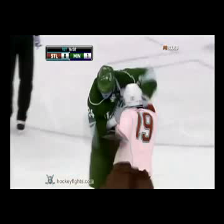

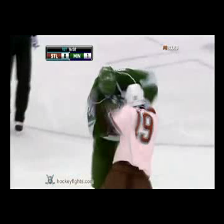

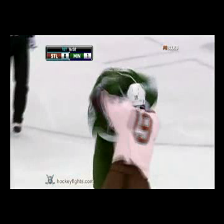

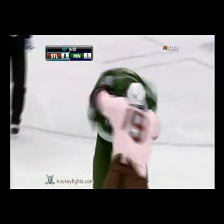

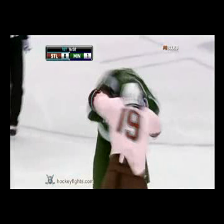

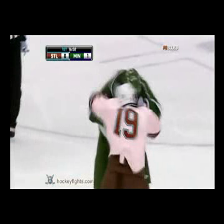

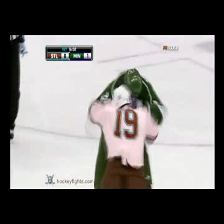

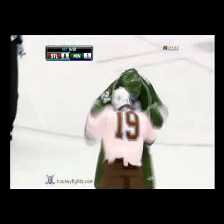

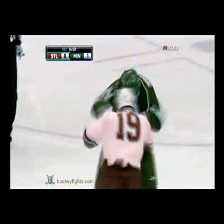

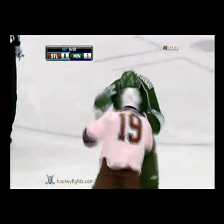

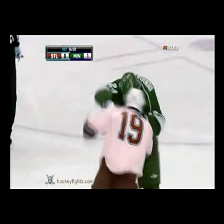

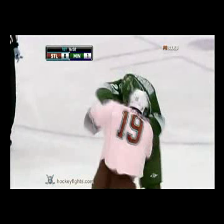

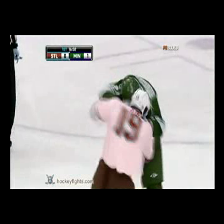

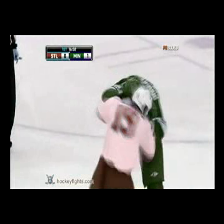

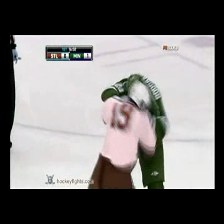

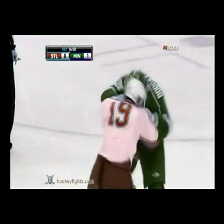

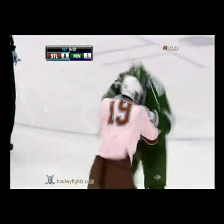

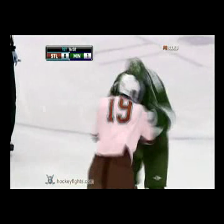

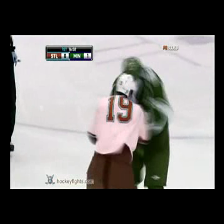

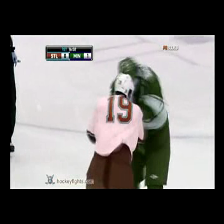

In [ ]:
# get frames of arbitrary video
random_num = np.random.randint(20)
frames = get_frames(data_dir, names_class['fi'][random_num])
visible_frames = (frames * 255).astype('uint8')

for frame in visible_frames:
    cv2_imshow(frame)

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.4587765634059906, y=0.3410530686378479, z=-0.23219139873981476, visibility=0.9990252256393433, presence=0.9998996257781982), NormalizedLandmark(x=0.4561520516872406, y=0.32187873125076294, z=-0.2151748389005661, visibility=0.9987253546714783, presence=0.9998020529747009), NormalizedLandmark(x=0.45980924367904663, y=0.3185257315635681, z=-0.21542948484420776, visibility=0.9981943964958191, presence=0.9997817873954773), NormalizedLandmark(x=0.46465176343917847, y=0.31491559743881226, z=-0.21533475816249847, visibility=0.9986942410469055, presence=0.9996527433395386), NormalizedLandmark(x=0.4403959810733795, y=0.3293459415435791, z=-0.20854705572128296, visibility=0.9993404746055603, presence=0.9998065829277039), NormalizedLandmark(x=0.43606945872306824, y=0.3304533362388611, z=-0.2088860124349594, visibility=0.9993908405303955, presence=0.9998431205749512), NormalizedLandmark(x=0.4323229193687439, y=0.3315776586532593, z=-0.209

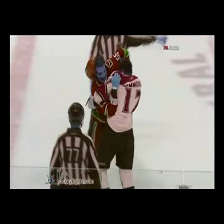

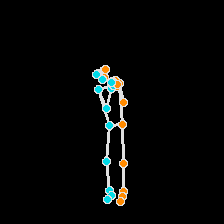

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.4609139859676361, y=0.34374648332595825, z=-0.5989503860473633, visibility=0.9989513158798218, presence=0.9999624490737915), NormalizedLandmark(x=0.4613669514656067, y=0.3253014087677002, z=-0.6013148427009583, visibility=0.9992616772651672, presence=0.9999246597290039), NormalizedLandmark(x=0.46694162487983704, y=0.3211413323879242, z=-0.6016421914100647, visibility=0.9988821148872375, presence=0.9999315738677979), NormalizedLandmark(x=0.47034719586372375, y=0.3176979422569275, z=-0.6016284227371216, visibility=0.9993409514427185, presence=0.9998927116394043), NormalizedLandmark(x=0.44821223616600037, y=0.33189913630485535, z=-0.5813685655593872, visibility=0.9993793964385986, presence=0.9998763799667358), NormalizedLandmark(x=0.44381216168403625, y=0.3325309157371521, z=-0.5817256569862366, visibility=0.9990212917327881, presence=0.9998650550842285), NormalizedLandmark(x=0.43809014558792114, y=0.3332713842391968, z=-0.58191

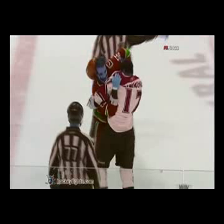

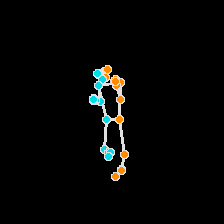

PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


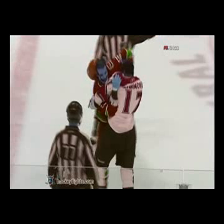

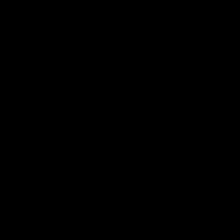

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.46224260330200195, y=0.3572850823402405, z=-0.4181371331214905, visibility=0.9925429821014404, presence=0.9988429546356201), NormalizedLandmark(x=0.46151599287986755, y=0.33330026268959045, z=-0.43024149537086487, visibility=0.9889527559280396, presence=0.9984834790229797), NormalizedLandmark(x=0.4662817418575287, y=0.3277002274990082, z=-0.4306391179561615, visibility=0.9889304041862488, presence=0.9987142086029053), NormalizedLandmark(x=0.4693962335586548, y=0.324379563331604, z=-0.43062496185302734, visibility=0.99029141664505, presence=0.9981932044029236), NormalizedLandmark(x=0.45120686292648315, y=0.3396031856536865, z=-0.39756959676742554, visibility=0.9905627965927124, presence=0.9980559349060059), NormalizedLandmark(x=0.4466968774795532, y=0.3401404023170471, z=-0.3980627655982971, visibility=0.9919890761375427, presence=0.9984427094459534), NormalizedLandmark(x=0.4438478946685791, y=0.34054601192474365, z=-0.3984900

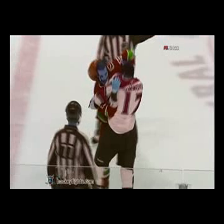

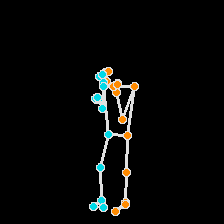

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.4658542275428772, y=0.3568202257156372, z=-0.5036559700965881, visibility=0.9966840147972107, presence=0.9993466734886169), NormalizedLandmark(x=0.46650734543800354, y=0.33494293689727783, z=-0.5133233070373535, visibility=0.9954921007156372, presence=0.9991963505744934), NormalizedLandmark(x=0.46949833631515503, y=0.33166590332984924, z=-0.5137366652488708, visibility=0.9955690503120422, presence=0.9993661046028137), NormalizedLandmark(x=0.4741571247577667, y=0.32675862312316895, z=-0.5137372016906738, visibility=0.9965327978134155, presence=0.9991650581359863), NormalizedLandmark(x=0.45544877648353577, y=0.3404565751552582, z=-0.4825270175933838, visibility=0.9955825209617615, presence=0.9986598491668701), NormalizedLandmark(x=0.4521844685077667, y=0.3404461145401001, z=-0.4830254018306732, visibility=0.9957972764968872, presence=0.9988383650779724), NormalizedLandmark(x=0.4468095600605011, y=0.3411751985549927, z=-0.483417

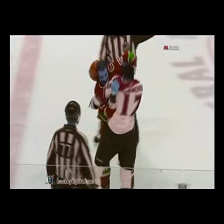

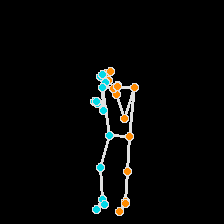

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.46834638714790344, y=0.3607831597328186, z=-0.2245015650987625, visibility=0.9894179701805115, presence=0.998754620552063), NormalizedLandmark(x=0.4692517817020416, y=0.339214563369751, z=-0.2271919846534729, visibility=0.9837110638618469, presence=0.9984728693962097), NormalizedLandmark(x=0.47401654720306396, y=0.3361850082874298, z=-0.2275518923997879, visibility=0.982920229434967, presence=0.9987491369247437), NormalizedLandmark(x=0.47746819257736206, y=0.3337615132331848, z=-0.2275288999080658, visibility=0.9878098964691162, presence=0.9983726143836975), NormalizedLandmark(x=0.45980870723724365, y=0.3455201983451843, z=-0.2000616043806076, visibility=0.9850817918777466, presence=0.9976792931556702), NormalizedLandmark(x=0.4554250240325928, y=0.3462776839733124, z=-0.20052437484264374, visibility=0.9871537089347839, presence=0.998018741607666), NormalizedLandmark(x=0.45246633887290955, y=0.3464757800102234, z=-0.2008599042

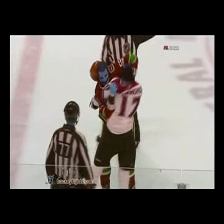

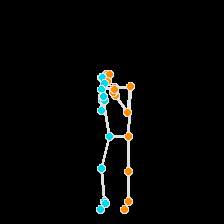

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.4671013653278351, y=0.35310137271881104, z=-0.19239000976085663, visibility=0.989535927772522, presence=0.9986421465873718), NormalizedLandmark(x=0.4674949645996094, y=0.33438003063201904, z=-0.18420173227787018, visibility=0.9807681441307068, presence=0.9983919262886047), NormalizedLandmark(x=0.4710899889469147, y=0.331339031457901, z=-0.18453465402126312, visibility=0.979432225227356, presence=0.9986479878425598), NormalizedLandmark(x=0.47554251551628113, y=0.3279779553413391, z=-0.18446429073810577, visibility=0.9851803779602051, presence=0.998199462890625), NormalizedLandmark(x=0.4571066200733185, y=0.3408183455467224, z=-0.16170655190944672, visibility=0.9840270280838013, presence=0.9974900484085083), NormalizedLandmark(x=0.4536808431148529, y=0.3432560861110687, z=-0.16211795806884766, visibility=0.9861308932304382, presence=0.9977770447731018), NormalizedLandmark(x=0.44952791929244995, y=0.34466972947120667, z=-0.16237

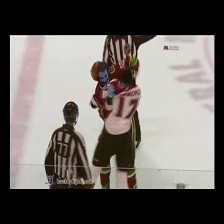

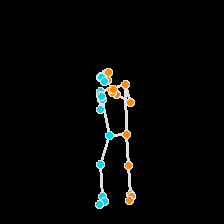

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.47154363989830017, y=0.34993278980255127, z=-0.22371840476989746, visibility=0.9952589869499207, presence=0.999306321144104), NormalizedLandmark(x=0.47385647892951965, y=0.33227288722991943, z=-0.21381312608718872, visibility=0.992446780204773, presence=0.9990376234054565), NormalizedLandmark(x=0.47624754905700684, y=0.326893150806427, z=-0.21414506435394287, visibility=0.9914976954460144, presence=0.9991540908813477), NormalizedLandmark(x=0.48103660345077515, y=0.3240317702293396, z=-0.21407857537269592, visibility=0.9931544065475464, presence=0.9988096952438354), NormalizedLandmark(x=0.4655296504497528, y=0.3362619876861572, z=-0.19278356432914734, visibility=0.9939919114112854, presence=0.9986342787742615), NormalizedLandmark(x=0.4626352787017822, y=0.3366132080554962, z=-0.19316713511943817, visibility=0.9947046637535095, presence=0.9988051652908325), NormalizedLandmark(x=0.45669177174568176, y=0.33813026547431946, z=-0.1

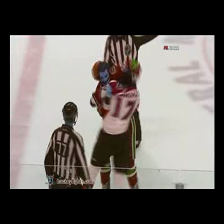

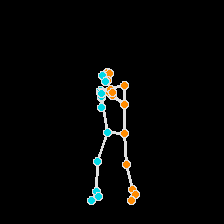

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.481307715177536, y=0.3327955901622772, z=-0.20774602890014648, visibility=0.9979123473167419, presence=0.9997209906578064), NormalizedLandmark(x=0.4817805290222168, y=0.31761276721954346, z=-0.18432877957820892, visibility=0.9955946803092957, presence=0.9995375871658325), NormalizedLandmark(x=0.4845946133136749, y=0.3154012858867645, z=-0.1846630722284317, visibility=0.9945545196533203, presence=0.9995576739311218), NormalizedLandmark(x=0.48847490549087524, y=0.3128446340560913, z=-0.18461038172245026, visibility=0.9956412315368652, presence=0.9993446469306946), NormalizedLandmark(x=0.4708234369754791, y=0.3236282169818878, z=-0.18055850267410278, visibility=0.9973189234733582, presence=0.9994685053825378), NormalizedLandmark(x=0.4664630889892578, y=0.3250712752342224, z=-0.18093456327915192, visibility=0.9978304505348206, presence=0.9995858073234558), NormalizedLandmark(x=0.46113166213035583, y=0.32670122385025024, z=-0.1812

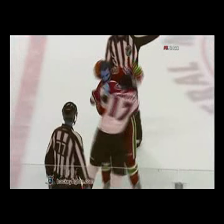

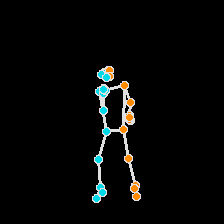

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.4800191819667816, y=0.3193683922290802, z=-0.10125035047531128, visibility=0.9982444047927856, presence=0.9998832941055298), NormalizedLandmark(x=0.48058879375457764, y=0.3054749071598053, z=-0.08163683861494064, visibility=0.9962654709815979, presence=0.9997536540031433), NormalizedLandmark(x=0.4835861921310425, y=0.3033761978149414, z=-0.08191433548927307, visibility=0.9946080446243286, presence=0.9997686743736267), NormalizedLandmark(x=0.4872235655784607, y=0.3010927438735962, z=-0.08183500915765762, visibility=0.9964268803596497, presence=0.9996720552444458), NormalizedLandmark(x=0.4704980254173279, y=0.3110024333000183, z=-0.07320250570774078, visibility=0.9981358051300049, presence=0.9997652173042297), NormalizedLandmark(x=0.4665152132511139, y=0.3128318190574646, z=-0.07354915142059326, visibility=0.9983046054840088, presence=0.9998310804367065), NormalizedLandmark(x=0.4620979130268097, y=0.31471002101898193, z=-0.0737

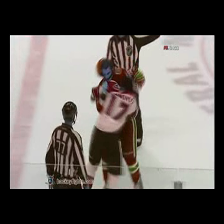

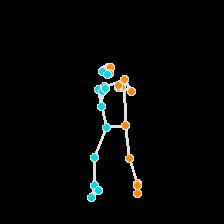

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.4925563931465149, y=0.3280681371688843, z=-0.14915940165519714, visibility=0.99826580286026, presence=0.9999020099639893), NormalizedLandmark(x=0.49381300806999207, y=0.31378671526908875, z=-0.12982051074504852, visibility=0.9957712292671204, presence=0.9997981190681458), NormalizedLandmark(x=0.49684253334999084, y=0.31195396184921265, z=-0.13008245825767517, visibility=0.9944726824760437, presence=0.9998059868812561), NormalizedLandmark(x=0.5001165866851807, y=0.3101876378059387, z=-0.1299687922000885, visibility=0.9957872033119202, presence=0.9997147917747498), NormalizedLandmark(x=0.48428070545196533, y=0.31666550040245056, z=-0.12385071069002151, visibility=0.9975200295448303, presence=0.9997790455818176), NormalizedLandmark(x=0.48005661368370056, y=0.3171257972717285, z=-0.12417435646057129, visibility=0.9978713989257812, presence=0.9998194575309753), NormalizedLandmark(x=0.4761619567871094, y=0.31766051054000854, z=-0.1

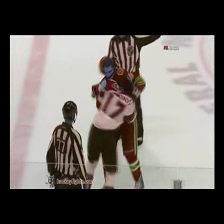

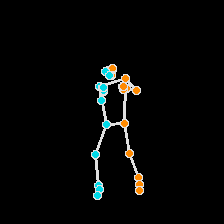

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.4985184073448181, y=0.3190980553627014, z=-0.15991634130477905, visibility=0.9950783252716064, presence=0.9995813965797424), NormalizedLandmark(x=0.5023363828659058, y=0.3031337559223175, z=-0.14751973748207092, visibility=0.9886232018470764, presence=0.9992257356643677), NormalizedLandmark(x=0.5063098669052124, y=0.30046334862709045, z=-0.14780163764953613, visibility=0.9867637753486633, presence=0.9992701411247253), NormalizedLandmark(x=0.5100380778312683, y=0.2979212999343872, z=-0.1477135270833969, visibility=0.9887823462486267, presence=0.9989351630210876), NormalizedLandmark(x=0.4920111894607544, y=0.3073492646217346, z=-0.13598795235157013, visibility=0.9927136301994324, presence=0.9991455078125), NormalizedLandmark(x=0.4878229796886444, y=0.30779004096984863, z=-0.1363351196050644, visibility=0.9943645000457764, presence=0.9993182420730591), NormalizedLandmark(x=0.48482075333595276, y=0.3079031705856323, z=-0.13656651

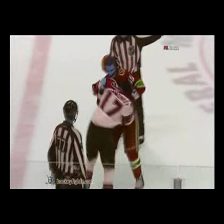

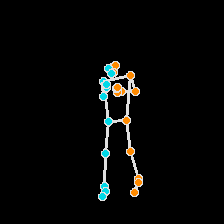

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.5060144066810608, y=0.315051406621933, z=-0.3893320560455322, visibility=0.996964156627655, presence=0.9996334314346313), NormalizedLandmark(x=0.5107846856117249, y=0.2998698949813843, z=-0.3784778416156769, visibility=0.9949483871459961, presence=0.9993085861206055), NormalizedLandmark(x=0.514286458492279, y=0.29808712005615234, z=-0.3788308799266815, visibility=0.9936967492103577, presence=0.9993570446968079), NormalizedLandmark(x=0.5184442400932312, y=0.2964479625225067, z=-0.37874144315719604, visibility=0.9951136708259583, presence=0.9990454316139221), NormalizedLandmark(x=0.500499427318573, y=0.3028357923030853, z=-0.36965224146842957, visibility=0.9964473843574524, presence=0.9991734623908997), NormalizedLandmark(x=0.497173547744751, y=0.3029654026031494, z=-0.3700011372566223, visibility=0.996841311454773, presence=0.999312162399292), NormalizedLandmark(x=0.49233683943748474, y=0.30320072174072266, z=-0.37026828527450

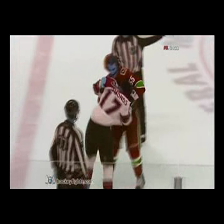

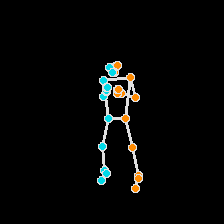

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.5173813104629517, y=0.3072320818901062, z=-0.27783194184303284, visibility=0.9973690509796143, presence=0.9994485974311829), NormalizedLandmark(x=0.5208427906036377, y=0.29223376512527466, z=-0.25953438878059387, visibility=0.995518147945404, presence=0.999079704284668), NormalizedLandmark(x=0.5246906280517578, y=0.2907463014125824, z=-0.25983110070228577, visibility=0.994584858417511, presence=0.9991775155067444), NormalizedLandmark(x=0.5278144478797913, y=0.2891467809677124, z=-0.2597357928752899, visibility=0.996044397354126, presence=0.9988715052604675), NormalizedLandmark(x=0.508928656578064, y=0.2961080074310303, z=-0.25489717721939087, visibility=0.9966805577278137, presence=0.9988144636154175), NormalizedLandmark(x=0.5048722624778748, y=0.2972496747970581, z=-0.25518593192100525, visibility=0.9967923760414124, presence=0.9989615678787231), NormalizedLandmark(x=0.5010768175125122, y=0.2983623743057251, z=-0.25541904568

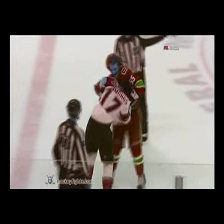

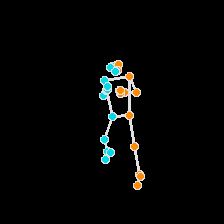

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.5171029567718506, y=0.31723687052726746, z=-0.2894405126571655, visibility=0.986099123954773, presence=0.9983055591583252), NormalizedLandmark(x=0.5207715630531311, y=0.30359476804733276, z=-0.2807650566101074, visibility=0.9712550044059753, presence=0.9965561628341675), NormalizedLandmark(x=0.5243441462516785, y=0.30183807015419006, z=-0.2810453772544861, visibility=0.9666973352432251, presence=0.9971591234207153), NormalizedLandmark(x=0.5279218554496765, y=0.2999286353588104, z=-0.28100788593292236, visibility=0.9758006930351257, presence=0.9961588382720947), NormalizedLandmark(x=0.5101979970932007, y=0.30662959814071655, z=-0.26764315366744995, visibility=0.9781870245933533, presence=0.9959760308265686), NormalizedLandmark(x=0.506846010684967, y=0.30680179595947266, z=-0.2679428160190582, visibility=0.9814119935035706, presence=0.9968981742858887), NormalizedLandmark(x=0.503207266330719, y=0.306843101978302, z=-0.268197208

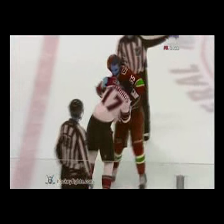

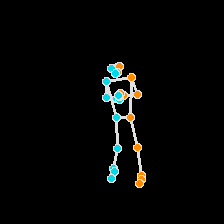

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.5220440030097961, y=0.3156880736351013, z=-0.2375337779521942, visibility=0.9977005124092102, presence=0.9997828602790833), NormalizedLandmark(x=0.5257484912872314, y=0.30086344480514526, z=-0.2207062691450119, visibility=0.9957183003425598, presence=0.9996063113212585), NormalizedLandmark(x=0.5292634963989258, y=0.29922813177108765, z=-0.22097386419773102, visibility=0.9947732090950012, presence=0.9996368885040283), NormalizedLandmark(x=0.5325719714164734, y=0.2979538142681122, z=-0.22087876498699188, visibility=0.9961259961128235, presence=0.9994736313819885), NormalizedLandmark(x=0.5141854882240295, y=0.30428463220596313, z=-0.21267478168010712, visibility=0.9968585968017578, presence=0.9995484948158264), NormalizedLandmark(x=0.5097393989562988, y=0.30552220344543457, z=-0.21295961737632751, visibility=0.9971627593040466, presence=0.9996209144592285), NormalizedLandmark(x=0.5055007338523865, y=0.30689501762390137, z=-0.213

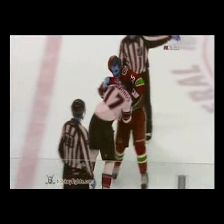

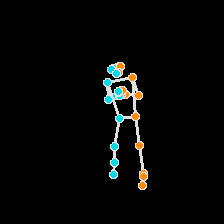

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.5221666693687439, y=0.3193940222263336, z=-0.24198538064956665, visibility=0.9951501488685608, presence=0.999567449092865), NormalizedLandmark(x=0.5253918766975403, y=0.30277347564697266, z=-0.23761513829231262, visibility=0.9895181059837341, presence=0.9993033409118652), NormalizedLandmark(x=0.529612123966217, y=0.30060121417045593, z=-0.23788702487945557, visibility=0.9889079928398132, presence=0.9993792772293091), NormalizedLandmark(x=0.5333967804908752, y=0.2986873984336853, z=-0.23780536651611328, visibility=0.990885317325592, presence=0.9991004467010498), NormalizedLandmark(x=0.5129074454307556, y=0.308462917804718, z=-0.21422669291496277, visibility=0.9919467568397522, presence=0.9991587400436401), NormalizedLandmark(x=0.5091506838798523, y=0.3097911477088928, z=-0.2145358920097351, visibility=0.993232250213623, presence=0.9992916584014893), NormalizedLandmark(x=0.5053420066833496, y=0.3112856447696686, z=-0.2147832363

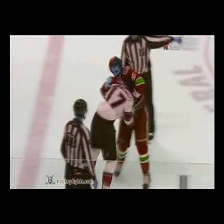

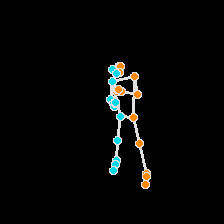

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.5284219980239868, y=0.3254464268684387, z=-0.4180247187614441, visibility=0.9923391342163086, presence=0.9995104074478149), NormalizedLandmark(x=0.5301876068115234, y=0.31178903579711914, z=-0.41696637868881226, visibility=0.9882530570030212, presence=0.9993367791175842), NormalizedLandmark(x=0.5334290266036987, y=0.3100489377975464, z=-0.4173186123371124, visibility=0.986831784248352, presence=0.9994206428527832), NormalizedLandmark(x=0.5372751355171204, y=0.30847620964050293, z=-0.4172363877296448, visibility=0.9900600910186768, presence=0.9991816878318787), NormalizedLandmark(x=0.5213391780853271, y=0.3146885633468628, z=-0.39847126603126526, visibility=0.9918609261512756, presence=0.9992103576660156), NormalizedLandmark(x=0.5188745856285095, y=0.31487351655960083, z=-0.39884668588638306, visibility=0.9931313395500183, presence=0.9993769526481628), NormalizedLandmark(x=0.5163750052452087, y=0.3150107264518738, z=-0.3991351

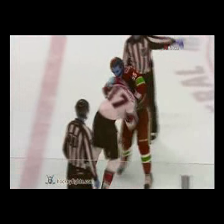

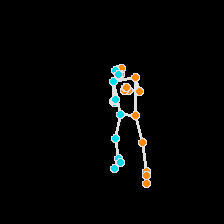

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.5351480841636658, y=0.3246327340602875, z=-0.16236983239650726, visibility=0.9918835163116455, presence=0.999535322189331), NormalizedLandmark(x=0.5354588627815247, y=0.30826908349990845, z=-0.1492346227169037, visibility=0.9800169467926025, presence=0.999320387840271), NormalizedLandmark(x=0.5394880175590515, y=0.3052746653556824, z=-0.14947688579559326, visibility=0.9801899790763855, presence=0.9993815422058105), NormalizedLandmark(x=0.5433977246284485, y=0.3027459383010864, z=-0.1493874341249466, visibility=0.9829025268554688, presence=0.9991575479507446), NormalizedLandmark(x=0.5253125429153442, y=0.31534653902053833, z=-0.13356618583202362, visibility=0.9862604737281799, presence=0.9990932941436768), NormalizedLandmark(x=0.522223949432373, y=0.3170689046382904, z=-0.1338728666305542, visibility=0.9890267252922058, presence=0.9991794228553772), NormalizedLandmark(x=0.5191614031791687, y=0.31857144832611084, z=-0.134068533

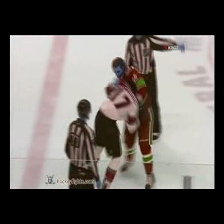

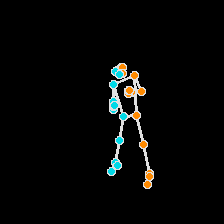

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.5387109518051147, y=0.3233240246772766, z=-0.08709733933210373, visibility=0.9995182752609253, presence=0.9999791383743286), NormalizedLandmark(x=0.541459858417511, y=0.30976730585098267, z=-0.08237256854772568, visibility=0.9991796612739563, presence=0.9999756813049316), NormalizedLandmark(x=0.5456333160400391, y=0.307658851146698, z=-0.08263077586889267, visibility=0.9991133809089661, presence=0.9999786615371704), NormalizedLandmark(x=0.5494276881217957, y=0.3053432106971741, z=-0.08254709839820862, visibility=0.9992947578430176, presence=0.9999709129333496), NormalizedLandmark(x=0.5320678949356079, y=0.31383979320526123, z=-0.05696667730808258, visibility=0.9993402361869812, presence=0.9999666213989258), NormalizedLandmark(x=0.5297500491142273, y=0.3146514892578125, z=-0.05727922543883324, visibility=0.9994400143623352, presence=0.9999715089797974), NormalizedLandmark(x=0.5270227789878845, y=0.3154940605163574, z=-0.057429

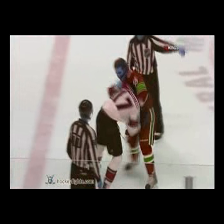

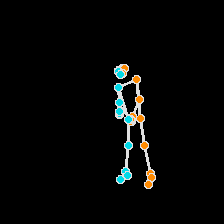

In [ ]:
detection_results = []
for visible_frame in visible_frames:
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=visible_frame)
    detection_result = pose_detector.detect(image)
    print(detection_result)
    detection_results.append(detection_result)
    annotated_image = draw_landmarks_on_image(np.zeros_like(visible_frame), detection_result)
    cv2_imshow(visible_frame)
    cv2_imshow(annotated_image)

In [ ]:
transfer_data = []
for i, x in enumerate(detection_results):
    pose_landmarks = x.pose_landmarks
    pose_landmarks = np.array(pose_landmarks).flatten()
    values = list(map(lambda obj: list([obj.x, obj.x, obj.y]), pose_landmarks))
    if len(values) == 0:
        values = np.zeros(shape=(33, 3))
    transfer_data.append(values)
transfer_data = np.array(transfer_data)
transfer_data.shape

(20, 33, 3)

In [ ]:
data_size = len(names)
train_size, val_size = int(data_size * 0.75), int(data_size * 0.25)
train_data, train_labels, val_data, val_labels = names[:train_size], labels[:train_size], names[train_size:], labels[train_size:]

In [ ]:
def get_detection_results(visible_frames):
    detection_results = []

    for visible_frame in visible_frames:
        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=visible_frame)
        detection_result = pose_detector.detect(image)
        detection_results.append(detection_result)
        annotated_image = draw_landmarks_on_image(np.zeros_like(visible_frame), detection_result)
        # cv2_imshow(visible_frame)
        # cv2_imshow(annotated_image)

    return detection_results

def get_transfer_data(data):
    result = []
    for filename in data:
        frames = get_frames(data_dir, filename)
        visible_frames = (frames * 255).astype('uint8')

        detection_results = get_detection_results(visible_frames)
        transfer_data = []
        for i, x in enumerate(detection_results):
            pose_landmarks = x.pose_landmarks
            pose_landmarks = np.array(pose_landmarks).flatten()
            values = np.array(list(map(lambda obj: list([obj.x, obj.y, obj.z]), pose_landmarks))).flatten()
            if len(values) == 0:
                values = np.zeros(shape=(99,))
            transfer_data.append(values)
        transfer_data = np.array(transfer_data)
        result.append(transfer_data)
    return result

def get_transfer_data_from_file(filename):
    frames = get_frames(data_dir, filename)
    visible_frames = (frames * 255).astype('uint8')

    detection_results = get_detection_results(visible_frames)
    transfer_data = []
    for i, x in enumerate(detection_results):
        pose_landmarks = x.pose_landmarks
        pose_landmarks = np.array(pose_landmarks).flatten()
        values = list(map(lambda obj: list([obj.x, obj.y, obj.z]), pose_landmarks))
        values = np.array(values).flatten()
        if len(values) == 0:
            values = np.zeros(shape=(99, ))
        transfer_data.append(values)
    return np.array(transfer_data)

In [ ]:
transfer_data = get_transfer_data(train_data)

### Save transfer data

In [ ]:
def save_transfer_data(transfer_data, labels, path):
    data = np.array(transfer_data)
    labels = np.array(labels)
    with h5py.File(path, 'w') as f:
        dset_data = f.create_dataset('data', shape=data.shape, chunks=data.shape, dtype=data.dtype)
        dset_labels = f.create_dataset('labels', shape=labels.shape, chunks=labels.shape, dtype=labels.dtype)

        dset_data[:] = data
        dset_labels[:] = labels

In [ ]:
save_transfer_data(data, labels, './transfer-data-test.h5')

### Load transfer data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/models/transfer-data.h5' './transfer-data.h5'

In [ ]:
import h5py

transfer_data_path = '/content/transfer-data.h5'
def load_transfer_data(path):
    if not os.path.exists(path):
        print("File not exist")

    with h5py.File(path, 'r') as f:
        dset_data = f['data'][:]
        dset_labels = f['labels'][:]
    return dset_data, dset_labels

In [ ]:
data, labels = load_transfer_data('./transfer-data-test.h5')

In [ ]:
data.shape, labels.shape

((1000, 20, 99), (1000, 2))

### Split train and validation data

In [ ]:
train_size = int(len(data) * 0.75)

train_data = np.array(data[:train_size])
train_labels = np.array(labels[:train_size])

val_data = np.array(data[train_size:])
val_labels = np.array(labels[train_size:])

(750, 20, 99)

### Training model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation


In [ ]:
chunk_size = 99
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50) )
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [ ]:
epoch = 100
batchS = 500

In [ ]:
history = model.fit(x=train_data, y=train_labels,
                    epochs=epoch,
                    validation_data=(val_data, val_labels),
                    batch_size=batchS,
                    verbose=2
                    )

Epoch 1/100
2/2 - 11s - loss: 0.2646 - accuracy: 0.5227 - val_loss: 0.2845 - val_accuracy: 0.4320 - 11s/epoch - 5s/step
Epoch 2/100
2/2 - 4s - loss: 0.2530 - accuracy: 0.5227 - val_loss: 0.2735 - val_accuracy: 0.4320 - 4s/epoch - 2s/step
Epoch 3/100
2/2 - 3s - loss: 0.2398 - accuracy: 0.5227 - val_loss: 0.2418 - val_accuracy: 0.4840 - 3s/epoch - 1s/step
Epoch 4/100
2/2 - 4s - loss: 0.2169 - accuracy: 0.6533 - val_loss: 0.2224 - val_accuracy: 0.6720 - 4s/epoch - 2s/step
Epoch 5/100
2/2 - 4s - loss: 0.2062 - accuracy: 0.7120 - val_loss: 0.2225 - val_accuracy: 0.6960 - 4s/epoch - 2s/step
Epoch 6/100
2/2 - 3s - loss: 0.2153 - accuracy: 0.6960 - val_loss: 0.2044 - val_accuracy: 0.7120 - 3s/epoch - 1s/step
Epoch 7/100
2/2 - 3s - loss: 0.1896 - accuracy: 0.7400 - val_loss: 0.2206 - val_accuracy: 0.6560 - 3s/epoch - 1s/step
Epoch 8/100
2/2 - 3s - loss: 0.2005 - accuracy: 0.7133 - val_loss: 0.2195 - val_accuracy: 0.6640 - 3s/epoch - 1s/step
Epoch 9/100
2/2 - 4s - loss: 0.1951 - accuracy: 0.7387

In [ ]:
result = model.evaluate(np.array(val_data), np.array(val_labels))

8/8 [==============================] - 1s 100ms/step - loss: 0.1821 - accuracy: 0.7760


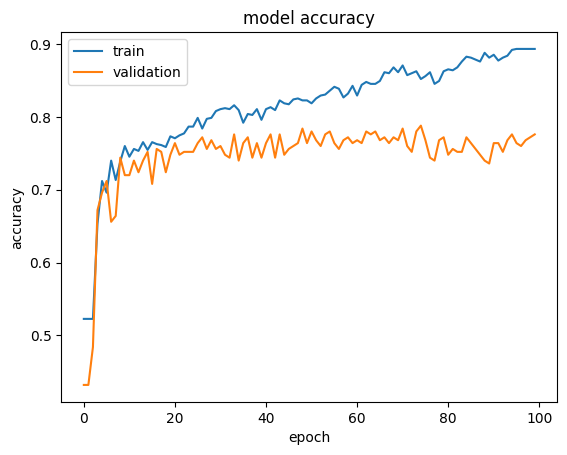

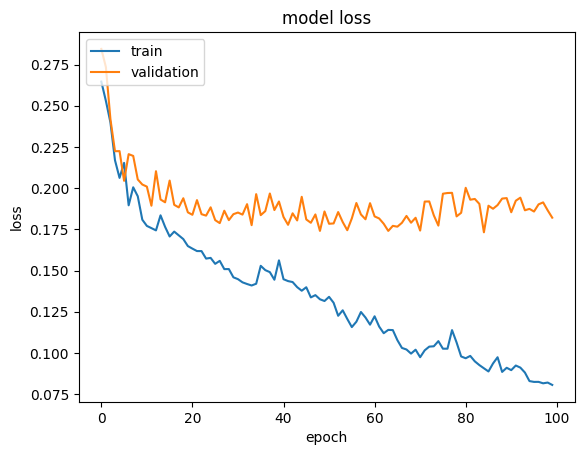

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

### Save model

In [ ]:
model.save('violence-detection-model')

In [ ]:
!cp -r ./violence-detection-model/ /content/drive/MyDrive/models

### Load model

In [ ]:
model = tf.keras.models.load_model('/content/violence-detection-model/')

### More evaluate

In [ ]:
root_path = '/content/data/Real Life Violence Dataset/'
violence_path = os.path.join(root_path, 'Violence')
nonviolence_path = os.path.join(root_path, 'NonViolence')

data_more = []
labels_more = []
for file in os.listdir(violence_path):
    data_more.append(os.path.join(violence_path, file))
    labels_more.append([1, 0])
for file in os.listdir(nonviolence_path):
    data_more.append(os.path.join(nonviolence_path, file))
    labels_more.append([0, 1])



In [ ]:
# evaluate = model.evaluate(np.array(data_more), np.array(labels_more))
# print(evaluate)

# pre processing data
t_data_more = get_transfer_data(data_more)
t_data_more

/content/data/Real Life Violence Dataset/Violence/V_701.mp4
/content/data/Real Life Violence Dataset/Violence/V_66.mp4
/content/data/Real Life Violence Dataset/Violence/V_791.mp4
/content/data/Real Life Violence Dataset/Violence/V_231.mp4
/content/data/Real Life Violence Dataset/Violence/V_658.mp4
/content/data/Real Life Violence Dataset/Violence/V_342.mp4
/content/data/Real Life Violence Dataset/Violence/V_820.mp4
/content/data/Real Life Violence Dataset/Violence/V_867.mp4
/content/data/Real Life Violence Dataset/Violence/V_741.mp4
/content/data/Real Life Violence Dataset/Violence/V_457.mp4
/content/data/Real Life Violence Dataset/Violence/V_420.mp4
/content/data/Real Life Violence Dataset/Violence/V_765.mp4
/content/data/Real Life Violence Dataset/Violence/V_41.mp4
/content/data/Real Life Violence Dataset/Violence/V_332.mp4
/content/data/Real Life Violence Dataset/Violence/V_751.mp4
/content/data/Real Life Violence Dataset/Violence/V_815.mp4
/content/data/Real Life Violence Dataset/V

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.5679552 ,  0.44562334, -0.36561438, ...,  0.49597144,
          0.7774815 , -0.31284115],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.03600922,  0.49526784, -0.14744839, ...,  0.8689667 ,
          0.67552149,  0.07537582],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [ ]:
save_transfer_data(t_data_more, labels_more, './transfer-data-more.h5')

In [ ]:
t_dataa, labelss = load_transfer_data('./transfer-data-more.h5')

In [ ]:
!cp ./transfer-data-more.h5 /content/drive/MyDrive/models/violence-detection-2-transfer-data-more.h5

In [ ]:
result = model.evaluate(np.array(t_data_more), np.array(labels_more))

63/63 [==============================] - 5s 83ms/step - loss: 0.4010 - accuracy: 0.5515


### Test

In [ ]:
root_path = '/content/data/Real Life Violence Dataset/'
violence_path = os.path.join(root_path, 'Violence')
nonviolence_path = os.path.join(root_path, 'NonViolence')

violences = []
for file in os.listdir(violence_path):
    violences.append(os.path.join(violence_path, file))

nonviolences = []
for file in os.listdir(nonviolence_path):
    nonviolences.append(os.path.join(nonviolence_path, file))

In [ ]:
for _ in range(10):
    random_num = np.random.randint(1000)
    filename = violences[np.random.randint(1000)]
    # frames = get_frames(data_dir, filename)
    # visible_frames = (frames * 255).astype('uint8')
    t_data = get_transfer_data_from_file(filename)
    media.show_video(media.read_video(filename))
    predict = model.predict(np.array([t_data]))

    label = np.argmax(predict)
    if label == 0:
        print("Violence", end=' ')
    else:
        print("Non violence", end=' ')
    print(f"p = {predict[0][label]}")

In [ ]:
model.predict(np.array([t_data]))

1/1 [==============================] - 0s 55ms/step


array([[0.4659133, 0.5340867]], dtype=float32)

In [ ]:
!pip install -q mediapy

In [ ]:
import mediapy as media
media.show_video(media.read_video(filename))

In [ ]:
predict.shape

(1, 2)